# TODO 

* Train epoch function
* print results

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from networks import fcn_8s
import numpy as np
import matplotlib.pyplot as plt
import time
import torchvision.models as models

In [2]:
from citydataset import city, cityscapes_classes, classes_city, maps_classes, facades_classes
from loss import cross_entropy2d,CrossEntropyLoss2d
from skimage.io import imread

## Dataset

### Folder

In [3]:
folder = r"./datasets/maps/"
mode = r"train"

In [4]:
df = city(mode = "train", classes=maps_classes)

## Training Function

## FCN

In [5]:
from torchvision.models.vgg import VGG

In [6]:

ranges = {
    'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
    'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
    'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
    'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
}

# cropped version from https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGGNet(VGG):
    def __init__(self, pretrained=True, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
        super().__init__(make_layers(cfg[model]))
        self.ranges = ranges[model]

        if pretrained:
            exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

        if not requires_grad:
            for param in super().parameters():
                param.requires_grad = False

        if remove_fc:  # delete redundant fully-connected layer params, can save memory
            del self.classifier

        if show_params:
            for name, param in self.named_parameters():
                print(name, param.size())

    def forward(self, x):
        output = {}

        # get the output of each maxpooling layer (5 maxpool in VGG net)
        for idx in range(len(self.ranges)):
            for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
                x = self.features[layer](x)
            output["x%d"%(idx+1)] = x

        return output

class FCN8s(torch.nn.Module):

    def __init__(self, pretrained_net, n_class):
        super().__init__()
        self.n_class = n_class
        self.pretrained_net = pretrained_net
        self.relu    = torch.nn.ReLU(inplace=True)
        self.deconv1 = torch.nn.ConvTranspose2d(512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1     = torch.nn.BatchNorm2d(512)
        self.deconv2 = torch.nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn2     = torch.nn.BatchNorm2d(256)
        self.deconv3 = torch.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn3     = torch.nn.BatchNorm2d(128)
        self.deconv4 = torch.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn4     = torch.nn.BatchNorm2d(64)
        self.deconv5 = torch.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5     = torch.nn.BatchNorm2d(32)
        self.classifier = torch.nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        output = self.pretrained_net(x)
        x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
        x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)
        x3 = output['x3']  # size=(N, 256, x.H/8,  x.W/8)

        score = self.relu(self.deconv1(x5))               # size=(N, 512, x.H/16, x.W/16)
        score = self.bn1(score + x4)                      # element-wise add, size=(N, 512, x.H/16, x.W/16)
        score = self.relu(self.deconv2(score))            # size=(N, 256, x.H/8, x.W/8)
        score = self.bn2(score + x3)                      # element-wise add, size=(N, 256, x.H/8, x.W/8)
        score = self.bn3(self.relu(self.deconv3(score)))  # size=(N, 128, x.H/4, x.W/4)
        score = self.bn4(self.relu(self.deconv4(score)))  # size=(N, 64, x.H/2, x.W/2)
        score = self.bn5(self.relu(self.deconv5(score)))  # size=(N, 32, x.H, x.W)
        score = self.classifier(score)                    # size=(N, n_class, x.H/1, x.W/1)

        return score # size=(N, n_class, x.H/1, x.W/1)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = torch.nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, torch.nn.BatchNorm2d(v), torch.nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, torch.nn.ReLU(inplace=True)]
            in_channels = v
    return torch.nn.Sequential(*layers)

In [7]:

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [torch.nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = torch.nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, torch.nn.BatchNorm2d(v), torch.nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, torch.nn.ReLU(inplace=True)]
            in_channels = v
    return torch.nn.Sequential(*layers)

In [8]:
vgg_model = VGGNet(requires_grad=True)

In [9]:
fp = FCN8s(pretrained_net=vgg_model, n_class=len(maps_classes))

In [10]:
fp.load_state_dict(torch.load(r"checkpoints/EXP_17/checkpoint.pth.tar"))

## Test training

In [11]:
batch = df[0]

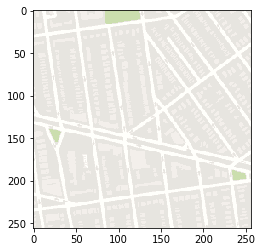

In [14]:
batch = df[0]
i =batch['image'].cpu()
m = batch['target'].cpu().data.numpy().astype(int)
del batch
plt.imshow(maps_classes[m].reshape(256,256,3))
plt.show()


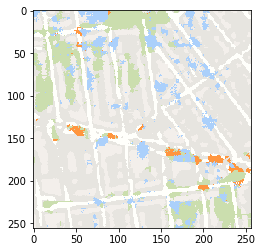

In [15]:
output = fp(i.unsqueeze(0))
tfa = output.view(len(maps_classes),256*256).permute(1,0).argmax(dim=1).data.cpu().numpy().reshape(-1,1)
plt.imshow(maps_classes[tfa].reshape(256,256,3))